# Testing the model on scraped amazon reviews
Due to resource limitations. I am using kaggle for GPU and TPU. Most of the steps are similar to the training setup.

In [58]:
# importing necessary libraries
import os
import time
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
import tensorflow as tf
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
#loading the reviews file
test_data = pd.read_csv('../input/phonereview/phone_review.csv')


# EDA of the testing data

Similar to the one we did for testing

In [3]:
# Basic information of test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Model-Name  100 non-null    object
 1   comment     100 non-null    object
 2   stars       100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [4]:
#Printing few values
test_data.head(5)

,Model-Name,comment,stars
0,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",\n\n\n\n\n\n\n\n\n\n \n \n \n Midrange s...,2.0 out of 5 stars
1,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",\n\n\n\n\n\n\n\n\n\n \n \n \n it should ...,2.0 out of 5 stars
2,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",\n\n\n\n\n\n\n\n\n\n \n \n \n Best camer...,5.0 out of 5 stars
3,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",\n\n\n\n\n\n\n\n\n\n \n \n \n Update - A...,3.0 out of 5 stars
4,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",\n\n\n\n\n\n\n\n\n\n \n \n \n Price is l...,5.0 out of 5 stars


In [5]:
#Cleaning the data 
test_data = test_data.replace('\n',' ', regex=True) 

In [6]:
#After cleaning
test_data.head(5)

,Model-Name,comment,stars
0,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Midrange specs ...flags...,2.0 out of 5 stars
1,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",it should be 22 k,2.0 out of 5 stars
2,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Best camera mobile,5.0 out of 5 stars
3,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Update - After few mont...,3.0 out of 5 stars
4,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Price is little bit hig...,5.0 out of 5 stars


In [7]:
test_data.describe()

,Model-Name,comment,stars
count,100,100,100
unique,10,100,5
top,"Samsung Galaxy A31 (Prism Crush Blue, 6GB RAM,...",Excellent Phone. Bought...,5.0 out of 5 stars
freq,10,1,43


In [8]:
# Converting list to string for word cloud
text=test_data['comment'].to_list()
text
def listToString(list):
    str1 = " "
    return (str1.join(list))


convertedStr = listToString(text)

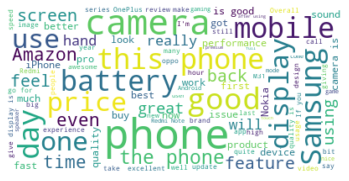

In [9]:
# Word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(convertedStr)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
#storing all the commentings in  a variable
test_reviews = test_data['comment'].values

In [11]:
#Initializing the Bert tokinerzer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [12]:
# Creating a function which will process the test data to be used as input to the bert model
import tqdm
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

MAX_SEQ_LENGTH = 500
test_features_ids,test_features_masks = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 100/100 [00:00<00:00, 196.37it/s]


In [13]:
#Creating a keras model
def get_training_model():
    inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
    inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
    inputs = [inp_id, inp_mask]

    hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
    pooled_output = hidden_state[:, 0]    
    dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
    drop1 = tf.keras.layers.Dropout(0.25)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(0.25)(dense2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                               epsilon=1e-08), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
#Configure TPU
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 32 * tpu_strategy.num_replicas_in_sync

In [15]:
# Loading the model with TPU
with tpu_strategy.scope():
    model = get_training_model()

In [16]:
# Loading the trained weights
model.load_weights("../input/trainedmodel/distillbert_ft_wts.h5")

In [17]:
# Predicting the scores
score = model.predict([test_features_ids, test_features_masks])

In [18]:
# Adding the scores and saving the data frame into csv file
test_data['score']=score
test_data.to_csv('review_score.csv')

In [19]:
test_data.head(15)

,Model-Name,comment,stars,score
0,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Midrange specs ...flags...,2.0 out of 5 stars,0.010950
1,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",it should be 22 k,2.0 out of 5 stars,0.146333
2,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Best camera mobile,5.0 out of 5 stars,0.998901
3,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Update - After few mont...,3.0 out of 5 stars,0.021436
4,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Price is little bit hig...,5.0 out of 5 stars,0.999345
5,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",It is funny to read som...,5.0 out of 5 stars,0.951961
6,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",This is best phone for ...,5.0 out of 5 stars,0.098151
7,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",THIS DISPLAY 6.53 IS AM...,5.0 out of 5 stars,0.183520
8,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Excellent Phone. Bought...,5.0 out of 5 stars,0.749310
9,"OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storag...",Not usefuldevice was ve...,1.0 out of 5 stars,0.000575


# EDA of scores

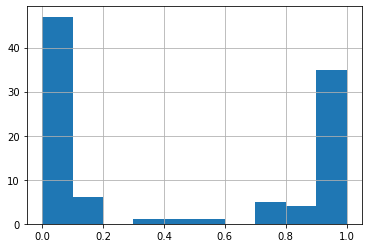

In [47]:
score = pd.read_csv('review_score.csv')
# Spread of the scores
hist = score['score'].hist()

In [51]:
for i in range(10):
    

'OPPO Reno2 F (Sky White, 8GB RAM, 128GB Storage) with No Cost EMI/Additional Exchange Offers'

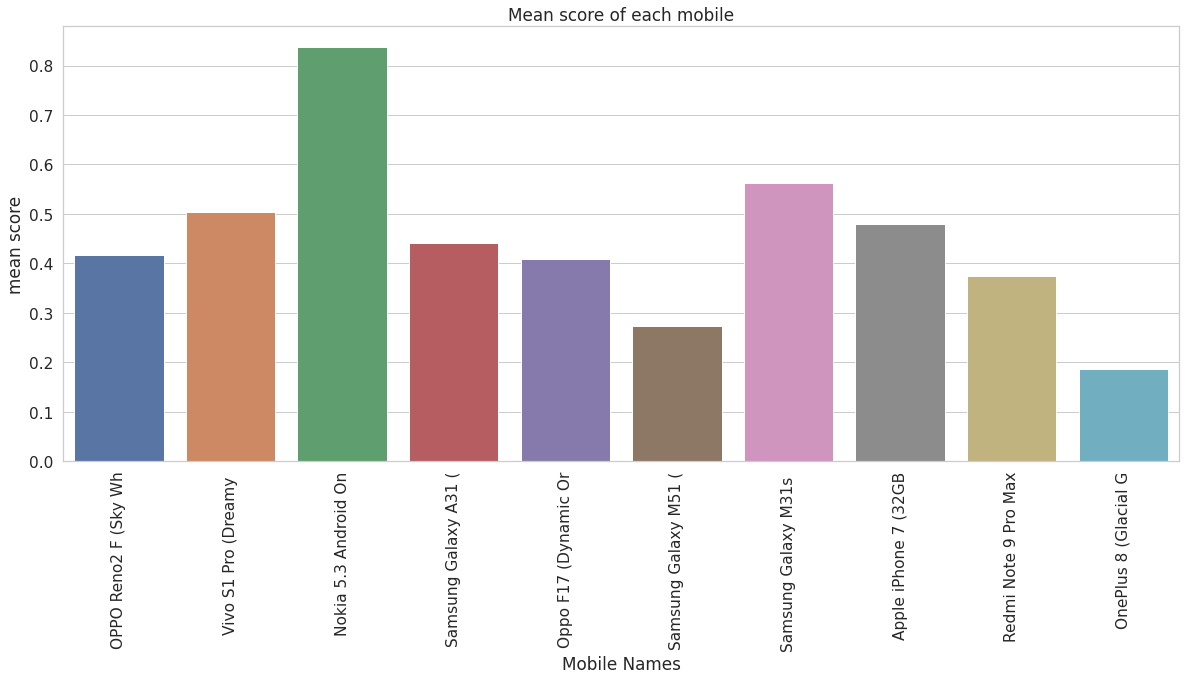

In [68]:
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
mean_score=[]
phone=score['Model-Name'].unique()
for i in range(len(phone)): 
    df=score.loc[score['Model-Name'] == phone[i]]
    mean_score.append(df['score'].mean())
    phone[i]=phone[i][0:17]
sns_rating = sns.barplot(x = phone, y = mean_score)

sns_rating.set(title = 'Mean score of each mobile', ylabel = 'mean score', xlabel = "Mobile Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

# Observations

It might look that the model is giving average performance by looking at the ratings and the scores. Most of the 1 rating comments are giving correct score but problem is with 5 rating scores. It might look that rating 5 always contains positive expression but that might not be the case everytime. For example, the 78th comment is "Amazon is providing best service during this pandemic.Flipkart is now worst e-commerce service.Delivered on time and mobile is too good." In this the score given by the model is less due to the word worst which is been more in focus. This can be easily avoided by training the model on more amazon reviews corpus.  